# Memory


### Long-Term Memory (LTM)


- The library of an LLM. It’s the vast, curated collection of data, storing everything from text to conceptual frameworks.

Applications include:

1. Vector databases

- These databases can store unstructured text data, providing the model with a
  reference point when generating content. By indexing and categorizing this data,
  LLMs can swiftly retrieve relevant information via similarity distance metrics.

2. Self-reflection

- Advanced applications include an LLM that introspects, records, and stores
  thoughts. Imagine an LLM that meticulously observes user patterns on a book
  review platform and catalogs these as deep insights. Over time, it pinpoints
  preferences, such as favored genres and writing styles. These insights are stored
  and accessed using retrieval. When users seek book recommendations, the LLM,
  powered by the retrieved context, provides bespoke suggestions aligned with their
  tastes.

3. Custom retrievers

- Creating specific retrieval functions can significantly boost an LLM’s efficiency.
  Drawing parallels with human memory systems, these functions can prioritize
  data based on its relevance, the elapsed time since the last memory, and its utility
  in achieving a particular objective.


### Short-Term Memory (STM)


- temporary workspace. Here, recent interactions, active tasks, or ongoing conversations are kept at the forefront to ensure continuity and context

Applications include:

1. Conversational histories

- For chatbots, tracking conversational history is essential. It allows the bot to
  maintain context over multiple exchanges, preventing redundant queries and
  ensuring the conversation flows naturally

2. Repetition avoidance

- STM proves invaluable when similar or identical queries are posed by users. By
  referencing its short-term recall, the model can provide consistent answers or
  diversify its responses, based on the application’s requirement.


### Short-Term Memory in QA Conversation Agents


Imagine Eva, a virtual customer support agent for an e-commerce platform. A user
might have several interlinked queries:

User: “How long is the return policy for electronics?”

Eva: “The return policy for electronics is 30 days.”

User: “What about for clothing items?”

Eva, leveraging STM: “For clothing items, it’s 45 days. Would you like to know
about any other categories?”

Notice that by utilizing short term memory (STM), Eva seamlessly continues the
conversation, anticipating potential follow-up questions. This fluidity is only possible due to the effective deployment of short-term memory, allowing the agent to perceive conversations not as isolated QAs but as a cohesive interaction.


# Memory in LangChain


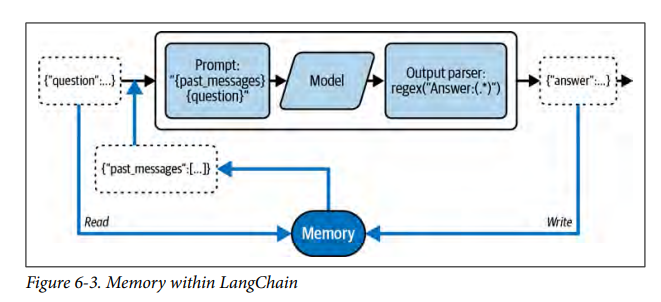


Process:

1. After collecting the initial user data but before executing, the chain retrieves information from its memory, adding to the user’s input.
2. After the chain has completed but before returning the answer, a chain will write
   the inputs and outputs of the current run to memory so that they can be referred
   to in future runs.


## Preserving the State


- the foundational memory of generative AI models is structured as a sequence of chat messages.
- These messages can be stored in temporary in-memory lists or anchored in a more durable database.
- there’s a wide range of [database integrations](https://python.langchain.com/v0.2/docs/integrations/memory/) available, streamlining the process and saving you from the hassle of manual integration.


In [3]:
from langchain_mongodb.chat_message_histories import MongoDBChatMessageHistory

# Provide the connection string to connect to the MongoDB database.
connection_string = "mongodb://localhost:27017"

chat_message_history = MongoDBChatMessageHistory(
    session_id="test_session",
    connection_string=connection_string,
    database_name="my_db",
    collection_name="chat_histories",
)

chat_message_history.add_user_message("I love programming!!")
chat_message_history.add_ai_message("What do you like about it?")
chat_message_history.messages

[HumanMessage(content='I love programming!!'),
 AIMessage(content='What do you like about it?')]

Reference: 01_LangChain_for_LLM_Application_Development/L2-Memory.ipynb


### ConversationBufferMemory


In [4]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'Human: hi\nAI: whats up'}

In [5]:
memory = ConversationBufferMemory(return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': [HumanMessage(content='hi'), AIMessage(content='whats up')]}

In [6]:
# Using within a chain:
from langchain.memory import ConversationBufferMemory
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

memory = ConversationBufferMemory(return_messages=True)

model = ChatOpenAI(temperature=0)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a chatbot that helps users with their queries."),
        # The history of the conversation
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

chain = (
    {
        "input": lambda x: x["input"],
        "history": RunnableLambda(memory.load_memory_variables) |
        itemgetter("history"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [8]:
inputs = {"input": "Hi my name is Fu Lim!"}
result = chain.invoke(inputs)
memory.save_context(inputs, {"outputs": result})
print(memory.load_memory_variables({}))

{'history': [HumanMessage(content='Hi my name is James!'), AIMessage(content='Hello James! How can I assist you today?'), HumanMessage(content='Hi my name is Fu Lim!'), AIMessage(content='Hello Fu Lim! How can I assist you today?')]}


In [9]:
inputs = {"input": "What is my name?"}
second_result = chain.invoke(inputs)
print(second_result)

Your name is Fu Lim. How can I assist you today, Fu Lim?


#### Example


In [45]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory

# 1. Create the model and memory:
model = ChatOpenAI(model="gpt-4o", temperature=0)
memory = ConversationBufferMemory(return_messages=True)


@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)


# 2. Create the tools:
tools = [get_word_length]

In [46]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# 3. Create the Prompt:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events and isn't good at calculating word length.",
        ),
        # This is where the agent will write/read its messages from
        MessagesPlaceholder(variable_name="agent_scratchpad"),
        MessagesPlaceholder(variable_name="history"),
        ("user", "{input}"),
    ]
)

In [47]:
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

# 4. Formats the python function tools into JSON schema and binds them to the model:
llm_with_tools = model.bind_tools(
    tools=[convert_to_openai_tool(t) for t in tools])


# 5. Setting up the agent chain:
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "history": RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [49]:
# Construct the OpenAI functions agent:
agent = create_openai_tools_agent(llm_with_tools, tools, prompt)

In [50]:
# Create an agent executor by passing in the agent, tools and memory:
memory = ConversationBufferMemory(return_messages=True)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, memory=memory)

In [51]:
agent_executor.invoke({"input": "My name is Wong Fu Lim"})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'Wong'}`


4
Invoking: `get_word_length` with `{'word': 'Fu'}`


2
Invoking: `get_word_length` with `{'word': 'Lim'}`


3Nice to meet you, Wong Fu Lim! How can I assist you today?

> Finished chain.


{'input': 'My name is Wong Fu Lim',
 'history': [HumanMessage(content='My name is Wong Fu Lim'),
  AIMessage(content='Nice to meet you, Wong Fu Lim! How can I assist you today?')],
 'output': 'Nice to meet you, Wong Fu Lim! How can I assist you today?'}

In [52]:
agent_executor.invoke(
    {"input": "What are the first three characters of my name?"})



> Entering new AgentExecutor chain...
The first three characters of your name "Wong Fu Lim" are "Won".

> Finished chain.


{'input': 'What are the first three characters of my name?',
 'history': [HumanMessage(content='My name is Wong Fu Lim'),
  AIMessage(content='Nice to meet you, Wong Fu Lim! How can I assist you today?'),
  HumanMessage(content='What are the first three characters of my name?'),
  AIMessage(content='The first three characters of your name "Wong Fu Lim" are "Won".')],
 'output': 'The first three characters of your name "Wong Fu Lim" are "Won".'}

### ConversationBufferWindowMemory


This type maintains a sliding window of the most recent interactions, ensuring the
buffer doesn’t grow excessively large. Features include the following:

- Keeps only the last K interactions
- Can return history as either a string or a list of messages


In [53]:
from langchain.memory import ConversationBufferWindowMemory
memory = ConversationBufferWindowMemory(k=1)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})

memory.load_memory_variables({})

{'history': 'Human: not much you\nAI: not much'}

### ConversationSummaryMemory

This one condenses and summarizes the conversation over time and is ideal for
longer conversations where verbatim message history would be token-expensive.
Features include the following:

- Summarizes conversation on the fly
- Can return history as a summary string or a list of system messages
- Allows direct prediction of new summaries
- Can be initialized with existing messages or summaries


In [54]:
from langchain.memory import ConversationSummaryMemory, ChatMessageHistory
from langchain_openai import OpenAI
memory = ConversationSummaryMemory(llm=OpenAI(temperature=0))
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': "\nThe human greets the AI and asks what's up. The AI responds by asking what's going on."}

### ConversationSummaryBufferMemory

This is a hybrid memory that maintains a buffer of recent interactions but also
compiles older interactions into a summary.
Features include the following:

- Uses token length to determine when to flush interactions
- Can return history as a summary with recent interactions or a list of messages
- Allows direct prediction of new summaries


In [55]:
from langchain.memory import ConversationSummaryBufferMemory
from langchain_openai.chat_models import ChatOpenAI
memory = ConversationSummaryBufferMemory(llm=ChatOpenAI(), max_token_limit=10)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'System: The human simply greets the AI with "hi."\nAI: whats up'}

### ConversationTokenBufferMemory

This one keeps a buffer of recent interactions using token length to determine when
to flush interactions.
Features include the following:

- Uses token length for flushing
- Can return history as a string or a list of messages


In [57]:
from langchain.memory import ConversationTokenBufferMemory
from langchain_openai.chat_models import ChatOpenAI
memory = ConversationTokenBufferMemory(llm=ChatOpenAI(),
                                       max_token_limit=10)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'AI: whats up'}

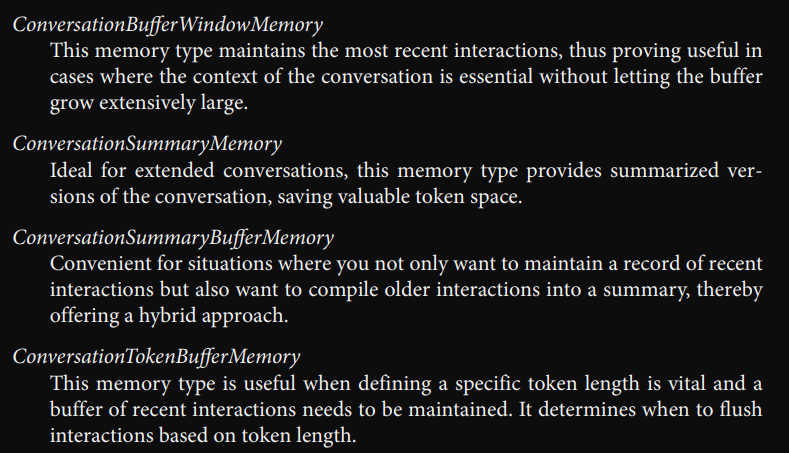


# OpenAI Functions Agent with Memory


# Custom Tools Memory Agent


In [58]:
from langchain.agents import create_openai_tools_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import SystemMessage
from langchain.tools import StructuredTool
from langchain_community.utilities.serpapi import SerpAPIWrapper
from dotenv import load_dotenv
load_dotenv()

True

In [59]:
# Define Tools:
def google_search(query: str):
    """Tool to search Google"""
    return SerpAPIWrapper().run(query)


def save_interview(raw_interview_text: str):
    """Tool to save the interview. You must pass the entire interview and conversation in here.
    The interview will then be saved to a local file. Remember to include all of the previous chat messages.
    Include all of the messages with the user and the AI, here is a good response:
    AI: some text
    Human: some text
    ...
    ---
    """
    # Save to local file:
    with open("interview.txt", "w") as f:
        f.write(raw_interview_text)
    return f"Interview saved! Content: {raw_interview_text}. File: interview.txt. You must tell the user that the interview is saved."


def get_pokemon(pokemon_name: str):
    """Tool to get a single Pokemon"""
    import requests
    clean_pokemon_name = pokemon_name.lower()
    # Get the Pokemon
    try:
        pokemon = requests.get(
            f"https://pokeapi.co/api/v2/pokemon/{clean_pokemon_name}").json()
        if pokemon:
            return f"Pokemon found! Name: {pokemon['name']}. Height: {pokemon['height']}. Weight: {pokemon['weight']}."
        else:
            return "Pokemon not found!"
    except Exception as e:
        print(e)
        return "Pokemon not found! Try a different pokemon."

StructuredTool.from_function() will create a LangChain tool that’s capable of
accepting multiple function arguments.


In [60]:
# Convert functions to Structured Tools:
google_search = StructuredTool.from_function(google_search)
save_interview = StructuredTool.from_function(save_interview)
get_single_pokemon = StructuredTool.from_function(get_pokemon)

In [61]:
from pydantic.v1 import BaseModel
from typing import Optional, Type, Union, Literal, List
from langchain.tools import BaseTool
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain.tools.base import ToolException
from langchain_core.documents import Document
import tempfile
import requests


class ArgumentType(BaseModel):
    url: str
    file_type: Union[Literal["pdf"], Literal["txt"]]


class SummarizeFileFromURL(BaseTool):
    name = "SummarizeFileFromURL"
    description = "Summarize a file from a URL."
    args_schema: Type[ArgumentType] = ArgumentType

    def _run(
        self,
        url: str,
        file_type: Union[Literal["pdf"], Literal["txt"]],
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool."""
        from langchain_community.document_loaders import PyPDFLoader, TextLoader
        from langchain.chains.summarize import load_summarize_chain

        response = requests.get(url)
        if response.status_code != 200:
            raise ToolException(
                "The URL is not valid. Please try another URL.")

        if file_type == "pdf":
            with tempfile.NamedTemporaryFile(suffix=".pdf", delete=True) as tmp:
                tmp.write(response.content)
                pdf_loader = PyPDFLoader(file_path=tmp.name)
                documents: List[Document] = pdf_loader.load()

        else:
            with tempfile.NamedTemporaryFile(suffix=".txt", delete=True, mode="w+t") as tmp:
                tmp.write(response.text)
                text_loader = TextLoader(tmp.name)
                documents: List[Document] = text_loader.load()

        chain = load_summarize_chain(llm=ChatOpenAI(), chain_type="map_reduce")
        return chain.run(documents)

    async def _arun(
        self,
        url: str,
        file_type: Union[Literal["pdf"], Literal["txt"]],
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("This tool does not support async yet!")


def _handle_error(error: ToolException) -> str:
    return (
        "The following errors occurred during tool execution:"
        + error.args[0]
        + "Please try another tool."
    )


file_summarizer = SummarizeFileFromURL()
file_summarizer.handle_tool_error = _handle_error

In [62]:
# Tools:
tools = [google_search, save_interview, get_single_pokemon, file_summarizer]

In [63]:
# Create the llm:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
llm = ChatOpenAI(temperature=0)


# Define the system message:
system_message = SystemMessage(
    content="""Act as a helpful AI interview assistant,
               Always ask a follow-up question, especially after returning results.
               Ask one question at a time.
               Always be in interview mode or tool mode.
               Ask the user about the desired topic.
               """
)

# Initialize memory:
memory = ConversationBufferMemory(memory_key="history", return_messages=True)

# Create the Prompt:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message,
        # This is where the user will write/read their messages from as memory
        MessagesPlaceholder(variable_name="history"),
        ("user", "{input}"),
        MessagesPlaceholder(
            variable_name="agent_scratchpad"
        ),  # This is where the agent will write/read its messages from
    ]
)

agent = create_openai_tools_agent(llm=llm, tools=tools, prompt=prompt)

In [65]:
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

# Formats the python function tools into JSON schema and binds them to the model:
llm_with_tools = llm.bind_tools(tools)


# Setting up the agent chain:
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
        "history": RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [66]:
# Create an agent executor by passing in the agent, tools and memory:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, memory=memory)

In [ ]:
agent_executor.invoke(
    {"input": "My name is James, I'm a computer programmer and I like to play cosy games."})